In [1]:
import pandas as pd

# Load the Excel file
file_path = '/Users/sishengliang/Desktop/Intern SF/Anomaly Detection in GL/Data file for students.xlsx'
excel_data = pd.ExcelFile(file_path)

# Load the "GL" sheet
gl_data = pd.read_excel(file_path, sheet_name='GL')

# Calculate the IQR for each Account_key's Details corresponding 'Amount'
def calculate_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    return IQR, Q1, Q3

# Function to identify outliers using IQR
def identify_outliers(data, Q1, Q3, IQR):
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    return outliers

# Group data by Account_key and Details
grouped_data = gl_data.groupby(['Account_key', 'Details'])

# Initialize results dictionary
results = []

# Iterate through each group and calculate outliers
for (account_key, details), group in grouped_data:
    amount_data = group['Amount']
    IQR, Q1, Q3 = calculate_iqr(amount_data)
    outliers = identify_outliers(amount_data, Q1, Q3, IQR)
    
    # Append results
    results.append({
        'Account_key': account_key,
        'Details': details,
        'Total Data Points': len(amount_data),
        'Number of Outliers': len(outliers)
    })

# Convert results to DataFrame for display
results_df = pd.DataFrame(results)

In [2]:
#generate the output excel file of results_df
results_df.to_excel('/Users/sishengliang/Desktop/Intern SF/Anomaly Detection in GL/Anomaly Detection Results.xlsx', index=False)

In [3]:
def display_outliers_summary(gl_data, account_key, details):
    # Filter data based on the specified Account_key and Details
    filtered_data = gl_data[(gl_data['Account_key'] == account_key) & (gl_data['Details'] == details)]
    
    # Check if the filtered data is empty
    if filtered_data.empty:
        print(f"No data found for Account_key: {account_key} and Details: {details}")
        return
    
    # Calculate IQR and identify outliers
    amount_data = filtered_data['Amount']
    IQR, Q1, Q3 = calculate_iqr(amount_data)
    outliers = identify_outliers(amount_data, Q1, Q3, IQR)
    
    # Create a summary DataFrame
    summary = pd.DataFrame({
        'Account_key': [account_key],
        'Details': [details],
        'Total Data Points': [len(amount_data)],
        'Number of Outliers': [len(outliers)]
    })
    
    # Display the summary
    print(summary)

In [4]:
# Example usage
display_outliers_summary(gl_data, 120, 'Credit Expenses')

   Account_key          Details  Total Data Points  Number of Outliers
0          120  Credit Expenses               2226                 123


In [6]:
import matplotlib.pyplot as plt

def show_boxplot(gl_data, account_key, details):
    # Filter data based on the specified Account_key and Details
    filtered_data = gl_data[(gl_data['Account_key'] == account_key) & (gl_data['Details'] == details)]
    
    # Check if the filtered data is empty
    if filtered_data.empty:
        print(f"No data found for Account_key: {account_key} and Details: {details}")
        return
    
    # Create a boxplot for the Amount column of the filtered data
    plt.figure(figsize=(10, 6))
    plt.boxplot(filtered_data['Amount'], vert=False)
    plt.title(f'Boxplot for Account_key: {account_key} and Details: {details}')
    plt.xlabel('Amount')
    plt.show()



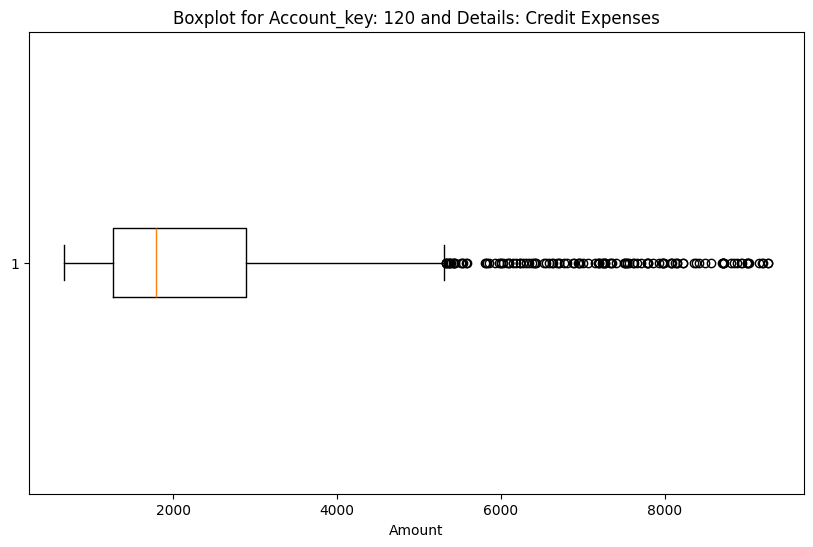

In [7]:
# Example usage
show_boxplot(gl_data, 120, 'Credit Expenses')

In [8]:
#Isolation Forest Algorithm
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import IsolationForest


# Step 1: Convert the 'Date' column to numerical format
gl_data['Date'] = pd.to_datetime(gl_data['Date'])
gl_data['Date'] = gl_data['Date'].map(pd.Timestamp.toordinal)

# Step 2: Encode the 'Details' column using one-hot encoding
encoder = OneHotEncoder()
encoded_details = encoder.fit_transform(gl_data[['Details']]).toarray()
encoded_details_df = pd.DataFrame(encoded_details, columns=encoder.get_feature_names_out(['Details']))

# Step 3: Normalize the 'Amount' column
scaler = StandardScaler()
gl_data['Amount'] = scaler.fit_transform(gl_data[['Amount']])

# Combine the processed columns into a single dataframe
processed_data = pd.concat([gl_data[['Date', 'Amount']], encoded_details_df], axis=1)

# Step 4: Apply the Isolation Forest algorithm
iso_forest = IsolationForest(contamination=0.1, random_state=42)
gl_data['anomaly'] = iso_forest.fit_predict(processed_data)
gl_data['anomaly_score'] = iso_forest.decision_function(processed_data)

# Step 5: Summarize the results
# -1 indicates an anomaly, 1 indicates normal
anomalies = gl_data[gl_data['anomaly'] == -1]

# Display the number of anomalies and the total number of data points
num_anomalies = anomalies.shape[0]
total_data_points = gl_data.shape[0]

print("Number of anomalies:", num_anomalies)
print("Total number of data points:", total_data_points)

# If you want to save the anomalies to a new Excel file
#anomalies.to_excel('/mnt/data/Anomalies.xlsx', index=False)


Number of anomalies: 2785
Total number of data points: 27909


Top 10 Anomalous Points:
        EntryNo    Date  Territory_key  Account_key  \
27908   1991.2  737790              7         1010   
27692   1983.2  737790              1         1010   
27439   1929.1  737759              1          200   
27907   1937.2  737759              7         1010   
27691   1929.2  737759              1         1010   
27440   1983.1  737790              1          200   
27655   1937.1  737759              7          200   
27835   1938.2  737759              5         1010   
27799   1937.2  737759              4         1010   
27906   1875.2  737729              7         1010   

                                           Details    Amount  Unnamed: 6  \
27908  Transfer of Net Profit to Retained Earnings -2.984224         NaN   
27692  Transfer of Net Profit to Retained Earnings -3.342418         NaN   
27439  Transfer of Net Profit to Retained Earnings  4.362858         NaN   
27907  Transfer of Net Profit to Retained Earnings -3.777491         NaN   

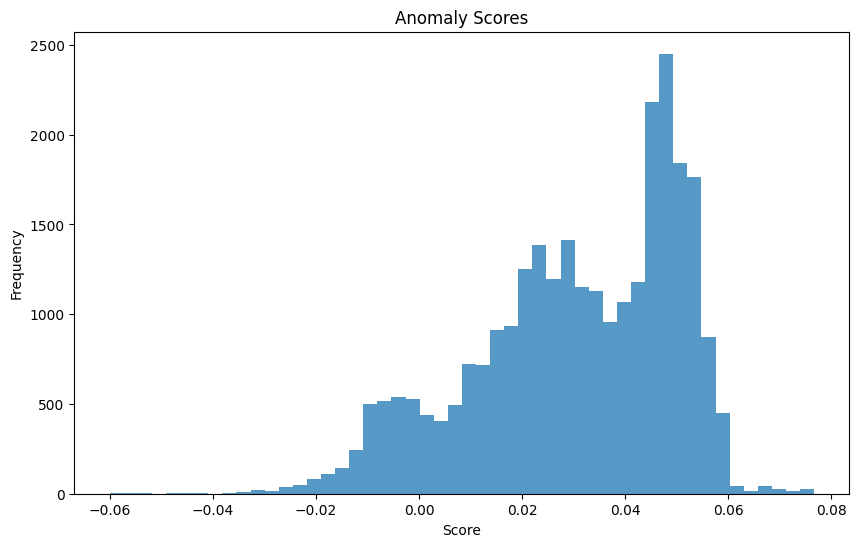

In [9]:

# Sort by anomaly score to inspect the most anomalous points
sorted_data = gl_data.sort_values(by='anomaly_score')

# Display the top 10 most anomalous points
print("Top 10 Anomalous Points:\n", sorted_data.head(10))

# Plot the anomaly scores
plt.figure(figsize=(10, 6))
plt.hist(gl_data['anomaly_score'], bins=50, alpha=0.75)
plt.title('Anomaly Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

Number of anomalies detected by LOF: 2791
Total number of data points: 27909
Top 10 Anomalous Points by LOF:
        EntryNo    Date  Territory_key  Account_key  \
21        11.2  736695              1           10   
3919       3.1  736695              2          280   
11766     11.2  736695              4           10   
1103     562.2  737009              1           10   
8933     562.2  737009              3           10   
12848    562.2  737009              4           10   
24593    562.2  737009              7           10   
16763    562.2  737009              5           10   
20678    562.2  737009              6           10   
5018     562.2  737009              2           10   

                          Details     Amount  Unnamed: 6  Unnamed: 7  \
21          Purchase of equipment -22.209492         NaN         NaN   
3919              Credit Expenses  -0.062127         NaN         NaN   
11766       Purchase of equipment -10.012219         NaN         NaN   
1103   

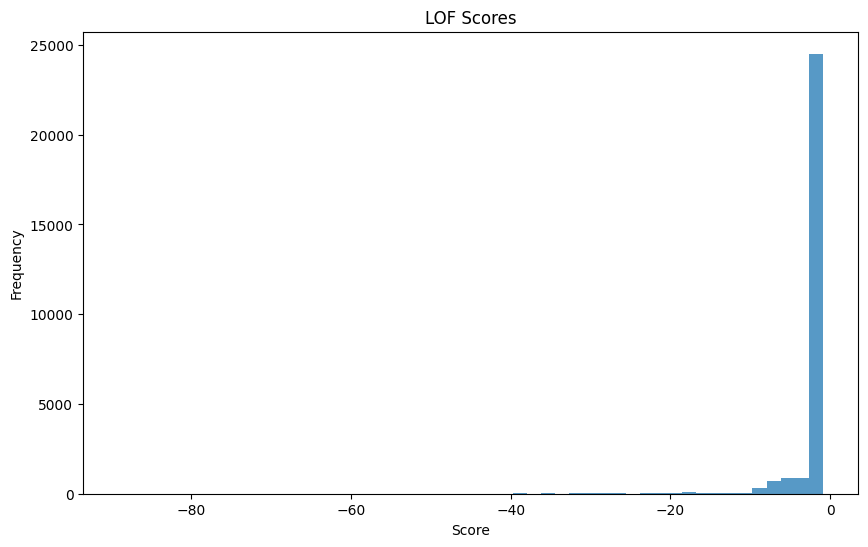

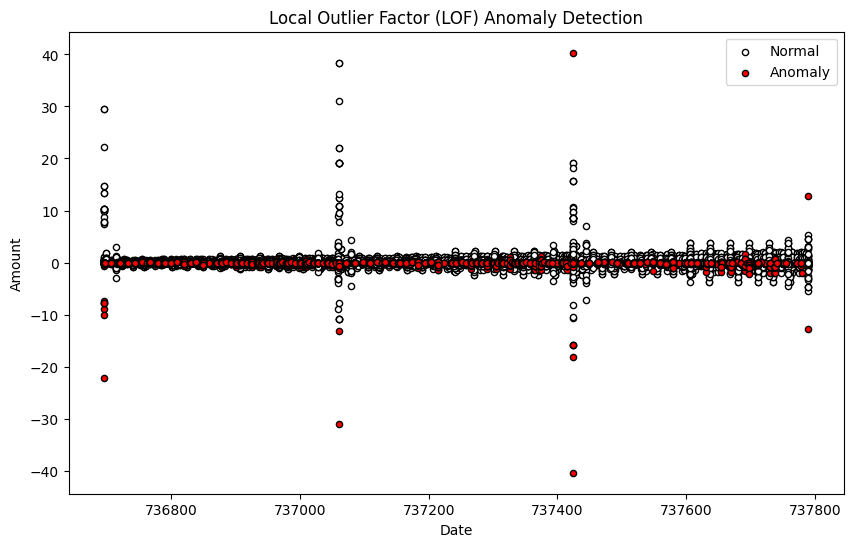

In [11]:

from sklearn.neighbors import LocalOutlierFactor
import numpy as np

# Step 1: Convert the 'Date' column to numerical format
#gl_data['Date'] = pd.to_datetime(gl_data['Date'])
#gl_data['Date'] = gl_data['Date'].map(pd.Timestamp.toordinal)

# Step 2: Encode the 'Details' column using one-hot encoding
encoder = OneHotEncoder()
encoded_details = encoder.fit_transform(gl_data[['Details']]).toarray()
encoded_details_df = pd.DataFrame(encoded_details, columns=encoder.get_feature_names_out(['Details']))

# Step 3: Normalize the 'Amount' column
scaler = StandardScaler()
gl_data['Amount'] = scaler.fit_transform(gl_data[['Amount']])

# Combine the processed columns into a single dataframe
processed_data = pd.concat([gl_data[['Date', 'Amount']], encoded_details_df], axis=1)

# Step 4: Apply the Local Outlier Factor algorithm
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
gl_data['anomaly_lof'] = lof.fit_predict(processed_data)
gl_data['lof_score'] = lof.negative_outlier_factor_

# Step 5: Summarize the results
# -1 indicates an anomaly, 1 indicates normal
anomalies_lof = gl_data[gl_data['anomaly_lof'] == -1]

# Display the number of anomalies and the total number of data points
num_anomalies_lof = anomalies_lof.shape[0]
total_data_points = gl_data.shape[0]

print("Number of anomalies detected by LOF:", num_anomalies_lof)
print("Total number of data points:", total_data_points)

# Sort by LOF score to inspect the most anomalous points
sorted_data_lof = gl_data.sort_values(by='lof_score')

# Display the top 10 most anomalous points
print("Top 10 Anomalous Points by LOF:\n", sorted_data_lof.head(10))

# Plot the LOF scores
plt.figure(figsize=(10, 6))
plt.hist(gl_data['lof_score'], bins=50, alpha=0.75)
plt.title('LOF Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

# Create a mesh grid for plotting the decision boundary (optional visualization)
xx, yy = np.meshgrid(np.linspace(gl_data['Date'].min() - 3, gl_data['Date'].max() + 3, 100),
                     np.linspace(gl_data['Amount'].min() - 50, gl_data['Amount'].max() + 50, 100))

# Plot the data points and decision boundary (optional visualization)
plt.figure(figsize=(10, 6))
plt.title("Local Outlier Factor (LOF) Anomaly Detection")

# Plot normal points
normal_lof = gl_data[gl_data['anomaly_lof'] == 1]
plt.scatter(normal_lof['Date'], normal_lof['Amount'], c='white', s=20, edgecolor='k', label="Normal")

# Plot anomalies
anomalies_lof = gl_data[gl_data['anomaly_lof'] == -1]
plt.scatter(anomalies_lof['Date'], anomalies_lof['Amount'], c='red', s=20, edgecolor='k', label="Anomaly")

plt.xlabel("Date")
plt.ylabel("Amount")
plt.legend()
plt.show()